In [118]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import os

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [119]:
from sklearn import preprocessing

Benjamin: cumulative_enrollment, stats_sd

Andrew: pubschools_info

Alex: border_crossings

In [120]:
border_crossings_path = os.path.join('Datasets', 'border_crossings.csv')
border_crossings = pd.read_csv(border_crossings_path, low_memory=False)

cumulative_enrollment_path = os.path.join('Datasets', 'cumulative_enrollment.csv')
cumulative_enrollment = pd.read_csv(cumulative_enrollment_path, low_memory=False)

pubschools_info_path = os.path.join('Datasets', 'pubschools_info.csv')
pubschools_info = pd.read_csv(pubschools_info_path, low_memory=False)

stats_sd_path = os.path.join('Datasets', 'COVID_19_Statistics_San_Diego_County.csv')
stats_sd = pd.read_csv(stats_sd_path, low_memory=False)

#I'm having a bit of trouble loading this one in for some reason, I'll check it out later.
#age_stats_sd_path = os.path.join('Datasets', 'COVID-19_Age_Statistics_by_ZIP_Code')
#age_stats_sd = pd.read_csv(age_stats_sd_path, low_memory=False)

### Checklist:
    1. Get dtypes in order
        change dates to object datetime
        natural numbers to int
        decimals to float
    2. Remove columns that are not relevant
    3. Remove the unneeded symbols from string data
    4. Replace null/blank/missing values with NaN
    5. Look for and understand suspicious or out of place values for each column
    6. Fill missing values or drop them as needed (for this one we can discuss among us which is the best method to deal with 
       missingness for each dataset, as there are a lot of ways to do them.
                                        

### Cumulative Enrollment

In [121]:
# #Removed insignificant columns
# #Changed all * values (missing for student privacy) to NaN, rest of CumulativeEnrollment to float.
# cumulative_clean = cumulative_enrollment.drop(['AcademicYear',"CountyCode", "DistrictCode", "SchoolCode"], axis=1) #Dropped codes
# cumulative_clean["CumulativeEnrollment"] = pd.to_numeric(cumulative_clean["CumulativeEnrollment"], errors='coerce')
# cumulative_clean["School, District"] = cumulative_clean["SchoolName"] + ", " + cumulative_clean["DistrictName"]

In [122]:
#Removed insignificant columns
#Changed all * values (missing for student privacy) to NaN, rest of CumulativeEnrollment to float.
cumulative_clean = cumulative_enrollment.drop(["AcademicYear", "CountyCode", "DistrictCode", "SchoolCode"], axis=1) #Dropped codes
cumulative_clean["CumulativeEnrollment"] = pd.to_numeric(cumulative_clean["CumulativeEnrollment"], errors='coerce')

In [123]:
cumulative_clean["School, District"] = cumulative_clean["SchoolName"] + ", " + cumulative_clean["DistrictName"]
cumulative_clean = cumulative_clean[cumulative_clean["AggregateLevel"] == "S"]
cumulative_clean = cumulative_clean[cumulative_clean["CountyName"] == "San Diego"]
cumulative_clean = cumulative_clean.rename(columns={'SchoolName': "School"})
cumulative_clean = cumulative_clean[cumulative_clean["Charter"] == "No "]
cumulative_clean = cumulative_clean.drop(["Charter"], axis=1)

latino = cumulative_clean.copy(deep=True)

cumulative_clean = cumulative_clean[cumulative_clean["ReportingCategory"] == "TA"]


latino = latino[latino["ReportingCategory"] == "RH"]
latino = latino[["ReportingCategory", "CumulativeEnrollment", "School, District"]]
latino_enrollment = cumulative_clean.merge(latino, on="School, District")
latino_enrollment["Latino%"] = latino_enrollment["CumulativeEnrollment_y"] / latino_enrollment["CumulativeEnrollment_x"]
latino_enrollment = latino_enrollment.drop(columns=["ReportingCategory_x", "ReportingCategory_y", "CumulativeEnrollment_y"])
latino_enrollment = latino_enrollment.rename(columns={"CumulativeEnrollment_x": "CumulativeEnrollment"})
cumulative_clean = latino_enrollment

In [124]:
# latinos = cumulative_clean[cumulative_clean['ReportingCategory'] == 'RH']
# latinos[latinos['CumulativeEnrollment'].isna() == False]
# # len(latinos)

### COVID-19 Stats in San Diego 

In [125]:
stats_sd["date"] = pd.to_datetime(stats_sd["date"])

### Border Crossing

In [126]:
months = ["January", "February", "March", "April", "May", "June", "July"]
border = pd.read_csv("Datasets/border_crossings.csv")
#Dropped nans
border = border.dropna(axis=0)
for month in months:
    border[month] = border[month].str.replace(',', '').astype(int)

### Public Schools

In [127]:
schools = pd.read_csv('Datasets/pubschools_info.csv')

schools = schools.loc[schools['County'] == 'San Diego']

cols_to_drop = ["NCESDist","NCESSchool","StreetAbr","MailStreet","MailStrAbr","MailCity",
               "MailZip","MailState","Ext","FaxNumber","Email","Phone","CharterNum",
                "FundingType","DOC","DOCType","EdOpsCode","EdOpsName","Magnet","FederalDFCDistrictID",
                "AdmFName","AdmLName","AdmEmail","YearRoundYN",'State', 
                'OpenDate',"SOC", "SOCType","GSoffered","GSserved",'ClosedDate']

schools = schools.drop(cols_to_drop, axis=1)

C:\Users\Andrew Chin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [128]:
clean1 = schools.loc[schools['StatusType'] == 'Active'] #Keeps only active schools
clean3 = clean1.loc[clean1['School'] != 'No Data'] #drops district records - nonschools
clean3['LastUpDate'] = pd.to_datetime(clean3['LastUpDate']) #change lastUpDate to datetime obj col
clean3 = clean3.reset_index().drop('index',axis = 1)
schools = clean3

schools = schools.replace("No Data",np.nan) #changed "No Data" into NaNs
schools['Latitude'] = schools['Latitude'].astype(float) #changed latitutde to float dtype
schools['Longitude'] = schools['Longitude'].astype(float) #changed longitude to float dtype
schools = schools.drop(['StatusType','County'],axis = 1) #dropped statustype and county col since its all active and SD county

# small_zip = schools['Zip'].str.slice(0,5).astype(float)
# schools = schools.assign(SmallZip=small_zip)

C:\Users\Andrew Chin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [129]:
address = schools['Street'] + ',' + schools['City'] + ",CA," + schools['Zip'].str.slice(0,5)
schools = schools.assign(Address = address).drop(["Street",'City'],axis = 1)
schools = schools.assign(Zipcode = schools['Zip'].str.slice(0,5))
schools['Zipcode'] = schools['Zipcode'].astype(int)

In [130]:
schools = schools.drop(columns=["Virtual"], axis=1)

In [131]:
type_of_schools = ['ELEM','HS','INTMIDJR','ELEMHIGH']
schools = schools[schools.EILCode.isin(type_of_schools)]

schools = schools.loc[schools['Charter'] == 'N']
schools = schools.drop(['EILCode','Charter'],axis = 1)


In [132]:
num_schools = len(schools)
unique_small_zips = schools['Zipcode'].nunique()
unique_zips = len(schools['Zip'].unique())
total_zips = len(schools['Zip'])

In [133]:
print("There are {} unique Zipcodes out of {}".format(unique_small_zips, total_zips))
print("There are {} unique Zips out of {}.".format(unique_zips,total_zips))

There are 90 unique Zipcodes out of 634
There are 577 unique Zips out of 634.


In [134]:
schools["School, District"] = schools["School"] + ", " + schools["District"]

In [135]:
schools

,CDSCode,District,School,Zip,WebSite,EILName,Latitude,Longitude,LastUpDate,Address,Zipcode,"School, District"
1,37103710115998,San Diego County Office of Education,San Pasqual Academy,92025-5301,http://www.sanpasqualacademy.org,High School,33.090580,-116.95009,2019-02-13,"17701 San Pasqual Valley Road,Escondido,CA,92025",92025,"San Pasqual Academy, San Diego County Office o..."
2,37103710120485,San Diego County Office of Education,Davila Day,91910-3604,NaN,Elementary,32.635041,-117.08832,2019-02-13,"540 G Street,Chula Vista,CA,91910",91910,"Davila Day, San Diego County Office of Education"
3,37103710120493,San Diego County Office of Education,Monarch,92113-1012,http://www.monarchschools.org,Elementary-High Combination,32.702375,-117.15045,2020-08-24,"1625 Newton Avenue,San Diego,CA,92113",92113,"Monarch, San Diego County Office of Education"
4,37103710128520,San Diego County Office of Education,San Diego County Community,92111-7399,http://www.sdcoe.net,Elementary-High Combination,32.769578,-117.17984,2020-08-21,"6401 Linda Vista Road, Room 216,San Diego,CA,9...",92111,"San Diego County Community, San Diego County O..."
5,37103710128538,San Diego County Office of Education,San Diego County Court,92123,http://www.sdcoe.net/jccs,High School,32.794147,-117.15396,2019-02-13,"2801 Meadow Lark Drive,San Diego,CA,92123",92123,"San Diego County Court, San Diego County Offic..."
14,37103711996545,San Diego County Office of Education,North Coastal Consortium Schools,92069-3709,http://nccse.org,Elementary-High Combination,33.142539,-117.16504,2019-02-13,"255 Pico Avenue, Room 220,San Marcos,CA,92069",92069,"North Coastal Consortium Schools, San Diego Co..."
15,37103716069355,San Diego County Office of Education,San Diego County Special Education,92111-7319,http://www.sdcoe.net,Elementary-High Combination,32.769409,-117.17960,2019-11-20,"6401 Linda Vista Road, Room 409,San Diego,CA,9...",92111,"San Diego County Special Education, San Diego ..."
17,37679676037535,Alpine Union Elementary,Joan MacQueen Middle,91901-3129,http://www.alpineschools.net/joanmac,Intermediate/Middle/Junior High,32.825432,-116.77538,2019-02-13,"2001 Tavern Road,Alpine,CA,91901",91901,"Joan MacQueen Middle, Alpine Union Elementary"
18,37679676106256,Alpine Union Elementary,Shadow Hills Elementary,91901-2615,http://www.alpineschools.net/shadowhills,Elementary,32.831900,-116.81522,2019-02-26,"8770 Harbison Canyon Road,Alpine,CA,91901",91901,"Shadow Hills Elementary, Alpine Union Elementary"
19,37679676109086,Alpine Union Elementary,Boulder Oaks Elementary,91901-3134,http://www.alpineschools.net/boulderoaks,Elementary,32.819163,-116.77617,2020-08-13,"2320 Tavern Road,Alpine,CA,91901",91901,"Boulder Oaks Elementary, Alpine Union Elementary"


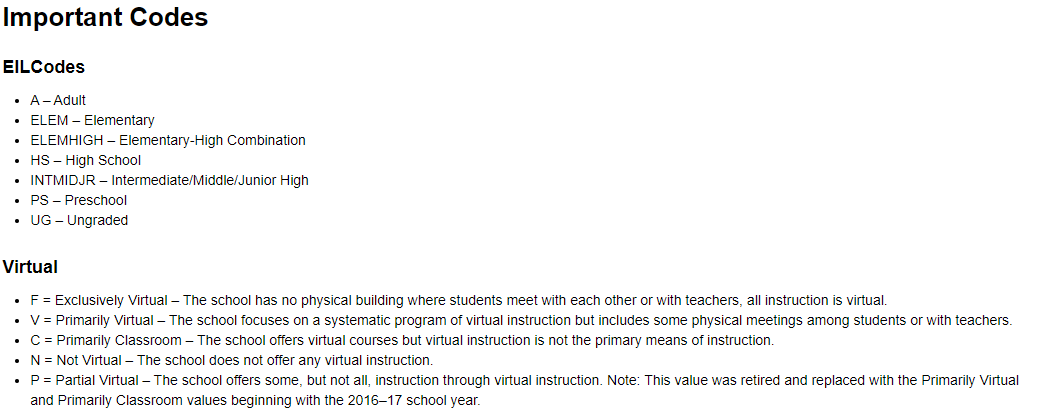

### Incomes

In [136]:
incomes_path = os.path.join('Datasets', 'suave_income.csv')
incomes = pd.read_csv(incomes_path, low_memory=False)

In [137]:
incomes_classes = incomes[["ZIP", 
         "Hholds with income Less than $10,000#number", 
         'Hholds with income $10,000 to $14,999#number',
         'Hholds with income $15,000 to $24,999#number',
         'Hholds with income $25,000 to $34,999#number',
         'Hholds with income $35,000 to $49,999#number',
         'Hholds with income $50,000 to $74,999#number',
         'Hholds with income $75,000 to $99,999#number',
         'Hholds with income $100,000 to $149,999#number',
         'Hholds with income $150,000 to $199,999#number',
         'Hholds with income $200,000 or more#number',
         'Median family income (dollars)#number',
         'Mean family income (dollars)#number',
         'Health insurance coverage, % of civilian pop#number',
         'No health insurance for civil pop#number',
         'No health insurance coverage, %#number',
         'Worked at home#number', 'Population 16+yo#number', 'Children of the hh 6-17 yo#number'
         ]]
incomes_clean = incomes_classes.copy()
incomes_clean["Households with income $0-34,999"] = (incomes_classes["Hholds with income Less than $10,000#number"] 
                                               + incomes_classes["Hholds with income $10,000 to $14,999#number"] 
                                               + incomes_classes["Hholds with income $15,000 to $24,999#number"] 
                                               + incomes_classes["Hholds with income $25,000 to $34,999#number"]
                                              )
incomes_clean["Households with income $35,000-99,999"] = (incomes_classes["Hholds with income $35,000 to $49,999#number"] 
                                               + incomes_classes["Hholds with income $50,000 to $74,999#number"] 
                                               + incomes_classes["Hholds with income $75,000 to $99,999#number"] 
                                              )
incomes_clean["Households with income $100,000+"] = (incomes_classes["Hholds with income $100,000 to $149,999#number"] 
                                               + incomes_classes["Hholds with income $150,000 to $199,999#number"]
                                               + incomes_classes["Hholds with income $200,000 or more#number"] 
                                              ) 
incomes_clean = incomes_clean.drop(["Hholds with income Less than $10,000#number", 
         'Hholds with income $10,000 to $14,999#number',
         'Hholds with income $15,000 to $24,999#number',
         'Hholds with income $25,000 to $34,999#number',
         'Hholds with income $35,000 to $49,999#number',
         'Hholds with income $50,000 to $74,999#number',
         'Hholds with income $75,000 to $99,999#number',
         'Hholds with income $100,000 to $149,999#number',
         'Hholds with income $150,000 to $199,999#number',
         'Hholds with income $200,000 or more#number',], axis=1)
incomes_clean = incomes_clean.rename(columns={'Median family income (dollars)#number': 'Median family income (dollars)',
                                             'Mean family income (dollars)#number' :'Mean family income (dollars)',
                                             'Health insurance coverage, % of civilian pop#number':'Health insurance coverage, % of civilian pop',
                                             'No health insurance for civil pop#number': 'No health insurance for civilian pop',
                                             'No health insurance coverage, %#number': 'No health insurance coverage %',
                                             'Worked at home#number': 'Worked at home',
                                             'ZIP': 'Zipcode', 'Population 16+yo#number':'Population 16+', 
                                             'Children of the hh 6-17 yo#number': 'Children of the household 6-17'})


In [138]:
pop = incomes_clean[["Zipcode", "Population 16+"]]

### Cleaned Demographics Data

In [139]:
cleaned_demo_path = os.path.join('Datasets', 'Cleaned_Demographics_Data.csv')
cleaned_demo = pd.read_csv(cleaned_demo_path, low_memory=False)


In [140]:
cleaned_demo

,Unnamed: 0,date,age_9,age10_19,age20_29,age30_39,age40_49,age50_59,age60_69,age70_79,age80_plus,ageunknow,genderfemale,gendermale,newtests,newcases,test_positivity_rate
0,14,2020/03/25 08:00:00+00,3,3,66,89,61,53,26,25,14,1,134,207,1087,58,0.053
1,15,2020/03/26 08:00:00+00,3,4,84,106,73,65,31,29,20,2,166,249,1023,76,0.074
2,16,2020/03/27 08:00:00+00,3,5,102,118,85,74,36,38,25,2,206,280,776,71,0.091
3,17,2020/03/28 08:00:00+00,4,6,107,130,90,79,37,39,26,1,219,298,1275,31,0.024
4,18,2020/03/29 08:00:00+00,4,6,121,148,105,91,52,45,29,2,256,345,687,84,0.122
5,19,2020/03/30 08:00:00+00,5,7,144,174,130,116,74,49,34,1,317,414,1538,131,0.085
6,20,2020/03/31 08:00:00+00,6,8,163,194,154,125,93,62,41,3,380,461,989,115,0.116
7,21,2020/04/01 08:00:00+00,8,9,187,216,170,149,108,71,45,3,439,514,2606,117,0.045
8,22,2020/04/02 08:00:00+00,10,12,198,238,192,177,136,88,55,6,519,585,1882,146,0.078
9,23,2020/04/03 08:00:00+00,10,14,209,251,212,202,152,91,64,4,570,630,1025,97,0.095


### Cleaned Cases by Zipcode

In [141]:
cleaned_cases_path = os.path.join('Datasets', 'Cleaned_Cases_by_Zipcode.csv')
cleaned_cases = pd.read_csv(cleaned_cases_path, low_memory=False)
#cleaned_cases = cleaned_cases.rename(columns={'Zipcode': 'Zip'})


In [142]:
recents = cleaned_cases[cleaned_cases['updatedate'] == cleaned_cases['updatedate'].max()]

cases_by_zip_dict = {}
# for cleaned_cases['Zipcode'].unique():
recents = cleaned_cases[cleaned_cases['updatedate'] == cleaned_cases['updatedate'].max()]
for index in recents.index.tolist():
    zipcode = recents.loc[index]['Zipcode']
    case_count = recents.loc[index]['case_count']
    if zipcode not in cases_by_zip_dict.keys():
        cases_by_zip_dict[zipcode] = case_count
    else:
        cases_by_zip_dict[zipcode] += case_count
        
max(cases_by_zip_dict, key=cases_by_zip_dict.get) #zip with highest number of cases

92154

In [143]:
cases_by_zip = pd.DataFrame(list(cases_by_zip_dict.items()),columns = ['Zipcode','Cases'])

### August Cases Increase

In [144]:
august_cases_path = os.path.join('Datasets', 'August_Case_Increase.csv')
august_cases = pd.read_csv(august_cases_path, low_memory=False)

In [145]:
august_cases = august_cases[["Zipcode", "Absolute Increase", "Percent Increase"]]

In [146]:
august_cases = august_cases.merge(pop, on="Zipcode")

In [147]:
august_cases["Absolute Increase Standardized"] = august_cases["Absolute Increase"] / august_cases["Population 16+"]

In [148]:
august_cases = august_cases.drop(["Absolute Increase", "Population 16+"], axis=1)

In [149]:
august_cases.head(1)

,Zipcode,Percent Increase,Absolute Increase Standardized
0,91901,23.08,0.001211


# Population by Zip Code

In [150]:
pop_by_zip_path = os.path.join('Datasets', 'Population by ZipCode.csv')
pop_by_zip = pd.read_csv(pop_by_zip_path, low_memory = False)
pop_by_zip = pop_by_zip.drop(['Unnamed: 0'], axis = 1)

In [151]:
pop_by_zip = pop_by_zip.rename(columns = {'ZIP code':'Zipcode' })
pop_by_zip.head(3)

,Zipcode,Population
0,91901,17403
1,91902,17653
2,91905,1700


# Data Exploration

In [152]:
zips = schools["Zipcode"].unique()

In [153]:
# cumulative_clean = cumulative_clean[cumulative_clean["AggregateLevel"] == "S"]

In [154]:
# cumulative_clean = cumulative_clean[cumulative_clean["CountyName"] == "San Diego"]
# cumulative_clean = cumulative_clean.rename(columns={'SchoolName': "School"})
# cumulative_clean = cumulative_clean[cumulative_clean["ReportingCategory"] == "TA"]

In [155]:
# cumulative_clean = cumulative_clean[cumulative_clean["Charter"] == "No "]

In [156]:
# cumulative_clean = cumulative_clean.drop(["Charter"], axis=1)

In [157]:
merged = schools.merge(cumulative_clean, on="School, District")

In [158]:
done = merged.merge(incomes_clean, on="Zipcode")

In [159]:
done = done.merge(august_cases, on="Zipcode")

In [160]:
done_shorter = done.drop(columns=["AggregateLevel", "CountyName", "CDSCode", 
                                  "Zip", "WebSite",
                                  "LastUpDate", "School_x", "School_y", "District"], axis=1)
# 'ReportingCategory' ^^

In [161]:
#Impute value for median family income for zip 91905 with that of 91906
done_shorter.loc[319, "Median family income (dollars)"] = 60240.0

In [162]:
done_shorter = done_shorter.merge(cases_by_zip)

In [163]:
done_shorter = done_shorter.merge(pop_by_zip)

# Standardizing

In [164]:
pop = done_shorter['Population']
household_pop = pop / 2.87

In [165]:
done_shorter = done_shorter.assign(WorkedAtHomeSTD=done_shorter['Worked at home'] / pop)

In [166]:
done_shorter = done_shorter.assign(HouseholdsIncome0kto35kSTD=done_shorter['Households with income $0-34,999'] / household_pop)

In [167]:
done_shorter = done_shorter.assign(HouseholdsIncome35kto100kSTD=done_shorter['Households with income $35,000-99,999'] / household_pop)

In [168]:
done_shorter = done_shorter.assign(HouseholdsIncome100kPlusSTD=done_shorter['Households with income $100,000+'] / household_pop)

In [169]:
done_shorter = done_shorter.assign(CasesSTD=done_shorter['Cases'] / pop)

In [170]:
done_shorter.columns

Index(['EILName', 'Latitude', 'Longitude', 'Address', 'Zipcode',
       'School, District', 'DistrictName', 'CumulativeEnrollment', 'Latino%',
       'Median family income (dollars)', 'Mean family income (dollars)',
       'Health insurance coverage, % of civilian pop',
       'No health insurance for civilian pop',
       'No health insurance coverage %', 'Worked at home', 'Population 16+',
       'Children of the household 6-17', 'Households with income $0-34,999',
       'Households with income $35,000-99,999',
       'Households with income $100,000+', 'Percent Increase',
       'Absolute Increase Standardized', 'Cases', 'Population',
       'WorkedAtHomeSTD', 'HouseholdsIncome0kto35kSTD',
       'HouseholdsIncome35kto100kSTD', 'HouseholdsIncome100kPlusSTD',
       'CasesSTD'],
      dtype='object')

In [224]:
cumulative_clean[cumulative_clean['School, District'] == 'Empower, Cajon Valley Union']

,AggregateLevel,CountyName,DistrictName,School,CumulativeEnrollment,"School, District",Latino%
115,S,San Diego,Cajon Valley Union,Empower,26.0,"Empower, Cajon Valley Union",NaN


In [233]:
# done_shorter[done_shorter['Latino%'].isna() == True]
done_shorter['Latino%'] = done_shorter['Latino%'].fillna(0)

In [234]:
from sklearn.cluster import KMeans
import sklearn.preprocessing as pp

In [235]:
# Numeric columns and associated transformers
num_feat = [
    'CumulativeEnrollment', 
    "Health insurance coverage, % of civilian pop", 
    "WorkedAtHomeSTD",
    'HouseholdsIncome0kto35kSTD',
    'HouseholdsIncome35kto100kSTD', 
    'HouseholdsIncome100kPlusSTD', 
    'CasesSTD',
    "Children of the household 6-17",
    "Absolute Increase Standardized",
    'Latino%'
]
num_transformer = Pipeline(steps=[
    ('scaler', pp.StandardScaler())   # z-scale
])

# Categorical columns and associated transformers
cat_feat = ['EILName', 'Zipcode']
cat_transformer = Pipeline(steps=[
    ('intenc', pp.OrdinalEncoder()),   # converts to int
    ('onehot', pp.OneHotEncoder())     # output from Ordinal becomes input to OneHot
])

# preprocessing pipeline (put them together)
preproc = ColumnTransformer(transformers=[('num', num_transformer, num_feat), ('cat', cat_transformer, cat_feat)])

pl = Pipeline(steps=[('preprocessor', preproc), ('kmeans', KMeans(n_clusters=3, n_init=1000))])

In [236]:
pl.fit(done_shorter)

C:\Users\Andrew Chin\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))]), ['CumulativeEnrollment', 'Health ...init=1000, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0))])

In [237]:
predictions = pl.predict(done_shorter)

In [238]:
done_shorter["predictions"] = predictions

In [239]:
done_shorter.columns

Index(['EILName', 'Latitude', 'Longitude', 'Address', 'Zipcode',
       'School, District', 'DistrictName', 'CumulativeEnrollment', 'Latino%',
       'Median family income (dollars)', 'Mean family income (dollars)',
       'Health insurance coverage, % of civilian pop',
       'No health insurance for civilian pop',
       'No health insurance coverage %', 'Worked at home', 'Population 16+',
       'Children of the household 6-17', 'Households with income $0-34,999',
       'Households with income $35,000-99,999',
       'Households with income $100,000+', 'Percent Increase',
       'Absolute Increase Standardized', 'Cases', 'Population',
       'WorkedAtHomeSTD', 'HouseholdsIncome0kto35kSTD',
       'HouseholdsIncome35kto100kSTD', 'HouseholdsIncome100kPlusSTD',
       'CasesSTD', 'predictions'],
      dtype='object')

In [240]:
print("0:", np.mean(done_shorter[done_shorter["predictions"] == 0]["CumulativeEnrollment"]))
print("1:", np.mean(done_shorter[done_shorter["predictions"] == 1]["CumulativeEnrollment"]))
print("2:", np.mean(done_shorter[done_shorter["predictions"] == 2]["CumulativeEnrollment"]))

0: 749.0585585585585
1: 845.0923076923077
2: 677.109022556391


In [241]:
print("0:", np.mean(done_shorter[done_shorter["predictions"] == 0]["Population 16+"]))
print("1:", np.mean(done_shorter[done_shorter["predictions"] == 1]["Population 16+"]))
print("2:", np.mean(done_shorter[done_shorter["predictions"] == 2]["Population 16+"]))

0: 48343.78828828829
1: 32871.692307692305
2: 32149.996240601504


In [242]:
print("0:", np.mean(done_shorter[done_shorter["predictions"] == 0]["Children of the household 6-17"]))
print("1:", np.mean(done_shorter[done_shorter["predictions"] == 1]["Children of the household 6-17"]))
print("2:", np.mean(done_shorter[done_shorter["predictions"] == 2]["Children of the household 6-17"]))

0: 9436.693693693695
1: 6863.507692307692
2: 4931.353383458647


In [243]:
print("0:", np.mean(done_shorter[done_shorter["predictions"] == 0]["No health insurance for civilian pop"]))
print("1:", np.mean(done_shorter[done_shorter["predictions"] == 1]["No health insurance for civilian pop"]))
print("2:", np.mean(done_shorter[done_shorter["predictions"] == 2]["No health insurance for civilian pop"]))

0: 9000.198198198199
1: 1967.8461538461538
2: 3530.5789473684213


In [244]:
print("0:", np.mean(done_shorter[done_shorter["predictions"] == 0]["Mean family income (dollars)"]))
print("1:", np.mean(done_shorter[done_shorter["predictions"] == 1]["Mean family income (dollars)"]))
print("2:", np.mean(done_shorter[done_shorter["predictions"] == 2]["Mean family income (dollars)"]))

0: 73937.12612612612
1: 162133.46923076923
2: 102848.21052631579


In [245]:
print("0:", np.mean(done_shorter[done_shorter["predictions"] == 0]["Worked at home"]))
print("1:", np.mean(done_shorter[done_shorter["predictions"] == 1]["Worked at home"]))
print("2:", np.mean(done_shorter[done_shorter["predictions"] == 2]["Worked at home"]))

0: 1237.7117117117118
1: 1946.9615384615386
2: 1277.733082706767


In [246]:
print("0:", np.mean(done_shorter[done_shorter["predictions"] == 0]["Households with income $0-34,999"]))
print("1:", np.mean(done_shorter[done_shorter["predictions"] == 1]["Households with income $0-34,999"]))
print("2:", np.mean(done_shorter[done_shorter["predictions"] == 2]["Households with income $0-34,999"]))

0: 5787.617117117117
1: 1951.7230769230769
2: 3366.6954887218044


In [247]:
print("0:", np.mean(done_shorter[done_shorter["predictions"] == 0]["Households with income $35,000-99,999"]))
print("1:", np.mean(done_shorter[done_shorter["predictions"] == 1]["Households with income $35,000-99,999"]))
print("2:", np.mean(done_shorter[done_shorter["predictions"] == 2]["Households with income $35,000-99,999"]))

0: 8164.828828828829
1: 4411.7307692307695
2: 6198.375939849624


In [248]:
print("0:", np.mean(done_shorter[done_shorter["predictions"] == 0]["Households with income $100,000+"]))
print("1:", np.mean(done_shorter[done_shorter["predictions"] == 1]["Households with income $100,000+"]))
print("2:", np.mean(done_shorter[done_shorter["predictions"] == 2]["Households with income $100,000+"]))

0: 3921.5765765765764
1: 8005.992307692308
2: 4781.9473684210525


In [249]:
print("0:", np.mean(done_shorter[done_shorter["predictions"] == 0]["Percent Increase"]))
print("1:", np.mean(done_shorter[done_shorter["predictions"] == 1]["Percent Increase"]))
print("2:", np.mean(done_shorter[done_shorter["predictions"] == 2]["Percent Increase"]))

0: 32.46058558558556
1: 25.478769230769235
2: 35.53116541353381


In [250]:
print("0:", np.mean(done_shorter[done_shorter["predictions"] == 0]["Absolute Increase Standardized"]))
print("1:", np.mean(done_shorter[done_shorter["predictions"] == 1]["Absolute Increase Standardized"]))
print("2:", np.mean(done_shorter[done_shorter["predictions"] == 2]["Absolute Increase Standardized"]))

0: 0.005677662911255926
1: 0.0014377421909451031
2: 0.0025381574599974994


In [251]:
print("0:", np.mean(done_shorter[done_shorter["predictions"] == 0]["CumulativeEnrollment"]))
print("1:", np.mean(done_shorter[done_shorter["predictions"] == 1]["CumulativeEnrollment"]))
print("2:", np.mean(done_shorter[done_shorter["predictions"] == 2]["CumulativeEnrollment"]))

0: 749.0585585585585
1: 845.0923076923077
2: 677.109022556391


In [252]:
print("0:", np.mean(done_shorter[done_shorter["predictions"] == 0]["CumulativeEnrollment"]))
print("1:", np.mean(done_shorter[done_shorter["predictions"] == 1]["CumulativeEnrollment"]))
print("2:", np.mean(done_shorter[done_shorter["predictions"] == 2]["CumulativeEnrollment"]))

0: 749.0585585585585
1: 845.0923076923077
2: 677.109022556391


In [253]:
print("0:", np.mean(done_shorter[done_shorter["predictions"] == 0]["CumulativeEnrollment"]))
print("1:", np.mean(done_shorter[done_shorter["predictions"] == 1]["CumulativeEnrollment"]))
print("2:", np.mean(done_shorter[done_shorter["predictions"] == 2]["CumulativeEnrollment"]))

0: 749.0585585585585
1: 845.0923076923077
2: 677.109022556391


In [254]:
done_shorter.columns

Index(['EILName', 'Latitude', 'Longitude', 'Address', 'Zipcode',
       'School, District', 'DistrictName', 'CumulativeEnrollment', 'Latino%',
       'Median family income (dollars)', 'Mean family income (dollars)',
       'Health insurance coverage, % of civilian pop',
       'No health insurance for civilian pop',
       'No health insurance coverage %', 'Worked at home', 'Population 16+',
       'Children of the household 6-17', 'Households with income $0-34,999',
       'Households with income $35,000-99,999',
       'Households with income $100,000+', 'Percent Increase',
       'Absolute Increase Standardized', 'Cases', 'Population',
       'WorkedAtHomeSTD', 'HouseholdsIncome0kto35kSTD',
       'HouseholdsIncome35kto100kSTD', 'HouseholdsIncome100kPlusSTD',
       'CasesSTD', 'predictions'],
      dtype='object')

# Visualizing Features 

Trying to find some correlation / meaning about the predictions

In [255]:
zero = done_shorter[done_shorter['predictions'] == 0]
one = done_shorter[done_shorter['predictions'] == 1]
two = done_shorter[done_shorter['predictions'] == 2]
cols = done_shorter.columns

## Lat and Long of schools 

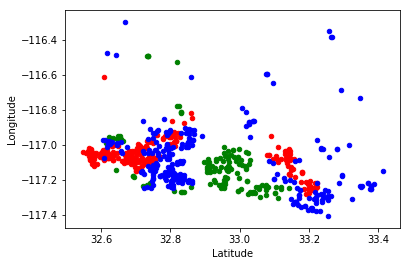

In [256]:
ax1 = zero.plot(kind='scatter', x='Latitude', y='Longitude', color='r')    #Zero schools r red
ax2 = one.plot(kind='scatter', x='Latitude', y='Longitude', color='g', ax=ax1)    #one schools r green
ax3 = two.plot(kind='scatter', x='Latitude', y='Longitude', color='b', ax=ax1)    #two schools r blue

## Health Insur Covg % vs Mean Fam Income 

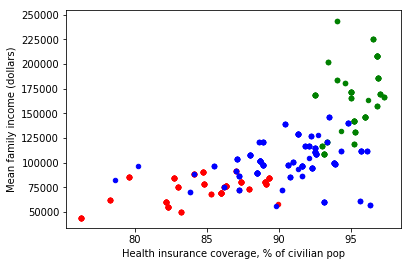

In [257]:
ax1 = zero.plot(kind='scatter', x='Health insurance coverage, % of civilian pop', y='Mean family income (dollars)', color='r')    #Zero schools r red
ax2 = one.plot(kind='scatter', x='Health insurance coverage, % of civilian pop', y='Mean family income (dollars)', color='g', ax=ax1)    #one schools r green
ax3 = two.plot(kind='scatter', x='Health insurance coverage, % of civilian pop', y='Mean family income (dollars)', color='b', ax=ax1)    #two schools r blue

## Health Insur Covg % vs Abs Inc Standardized (covid cases inc)

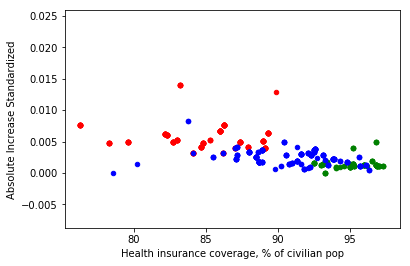

In [258]:
ax1 = zero.plot(kind='scatter', x='Health insurance coverage, % of civilian pop', y='Absolute Increase Standardized', color='r')    #Zero schools r red
ax2 = one.plot(kind='scatter', x='Health insurance coverage, % of civilian pop', y='Absolute Increase Standardized', color='g', ax=ax1)    #one schools r green
ax3 = two.plot(kind='scatter', x='Health insurance coverage, % of civilian pop', y='Absolute Increase Standardized', color='b', ax=ax1)    #two schools r blue

## Mean fam income vs Abs Inc Standardized(covid cases increase)

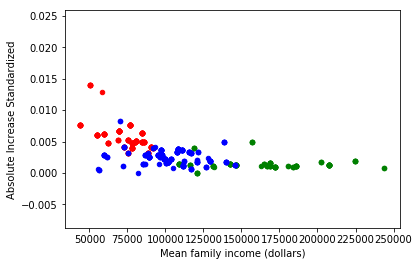

In [259]:
ax1 = zero.plot(kind='scatter', x='Mean family income (dollars)', y='Absolute Increase Standardized', color='r')    #Zero schools r red
ax2 = one.plot(kind='scatter', x='Mean family income (dollars)', y='Absolute Increase Standardized', color='g', ax=ax1)    #one schools r green
ax3 = two.plot(kind='scatter', x='Mean family income (dollars)', y='Absolute Increase Standardized', color='b', ax=ax1)    #two schools r blue

In [260]:
print("0 mean Abs Inc Standardized: ", zero['Absolute Increase Standardized'].mean()* 100 ,' %')
print("1 mean Abs Inc Standardized: ", one['Absolute Increase Standardized'].mean() * 100 ,' %')
print("2 mean Abs Inc Standardized: ", two['Absolute Increase Standardized'].mean() * 100 ,' %')

0 mean Abs Inc Standardized:  0.5677662911255926  %
1 mean Abs Inc Standardized:  0.14377421909451032  %
2 mean Abs Inc Standardized:  0.25381574599974993  %


## Health Insur Covg % vs # of Cases of that zip

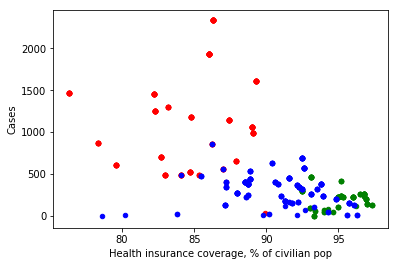

In [261]:
ax1 = zero.plot(kind='scatter', x='Health insurance coverage, % of civilian pop', y='Cases', color='r')    #Zero schools r red
ax2 = one.plot(kind='scatter', x='Health insurance coverage, % of civilian pop', y='Cases', color='g', ax=ax1)    #one schools r green
ax3 = two.plot(kind='scatter', x='Health insurance coverage, % of civilian pop', y='Cases', color='b', ax=ax1)    #two schools r blue

## Worked at home vs # of Cases

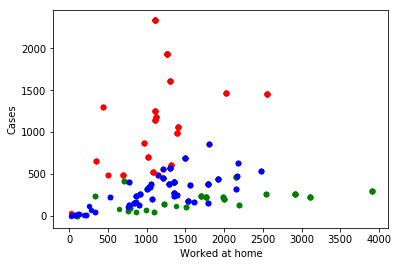

In [262]:
ax1 = zero.plot(kind='scatter', x='Worked at home', y='Cases', color='r')    #Zero schools r red
ax2 = one.plot(kind='scatter', x='Worked at home', y='Cases', color='g', ax=ax1)    #one schools r green
ax3 = two.plot(kind='scatter', x='Worked at home', y='Cases', color='b', ax=ax1)    #two schools r blue

## Mean Fam income vs # of cases

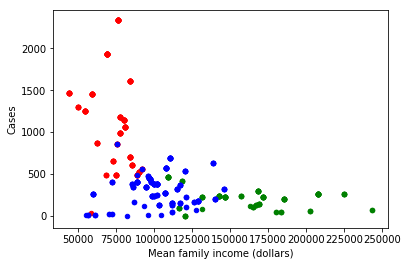

In [263]:
ax1 = zero.plot(kind='scatter', x='Mean family income (dollars)', y='Cases', color='r')    #Zero schools r red
ax2 = one.plot(kind='scatter', x='Mean family income (dollars)', y='Cases', color='g', ax=ax1)    #one schools r green
ax3 = two.plot(kind='scatter', x='Mean family income (dollars)', y='Cases', color='b', ax=ax1)    #two schools r blue

## Cumulative Enrollment vs # of Cases

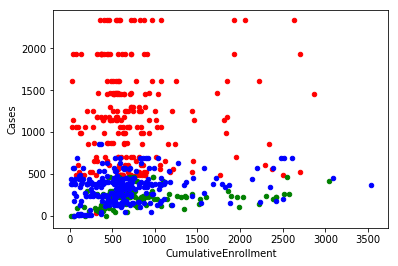

In [264]:
ax1 = zero.plot(kind='scatter', x='CumulativeEnrollment', y='Cases', color='r')    #Zero schools r red
ax2 = one.plot(kind='scatter', x='CumulativeEnrollment', y='Cases', color='g', ax=ax1)    #one schools r green
ax3 = two.plot(kind='scatter', x='CumulativeEnrollment', y='Cases', color='b', ax=ax1)    #two schools r blue

In [265]:
print(len(two),len(zero),len(one))

266 222 130


## No Health Insurance pop vs # of cases

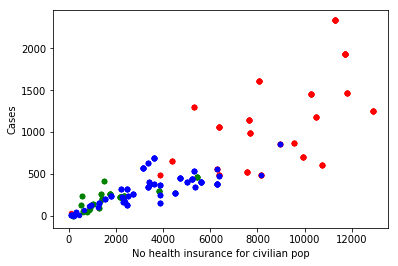

In [266]:
ax1 = zero.plot(kind='scatter', x='No health insurance for civilian pop', y='Cases', color='r')    #Zero schools r red
ax2 = one.plot(kind='scatter', x='No health insurance for civilian pop', y='Cases', color='g', ax=ax1)    #one schools r green
ax3 = two.plot(kind='scatter', x='No health insurance for civilian pop', y='Cases', color='b', ax=ax1)    #two schools r blue

## Households with income 35,000-99,999 vs Population 16+

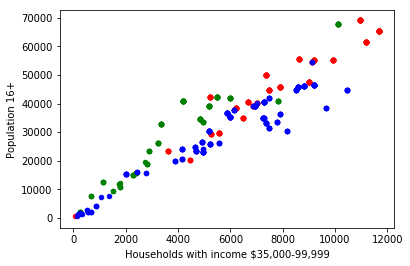

In [267]:
ax1 = zero.plot(kind='scatter', x='Households with income $35,000-99,999', y='Population 16+', color='r')    #Zero schools r red
ax2 = one.plot(kind='scatter', x='Households with income $35,000-99,999', y='Population 16+', color='g', ax=ax1)    #one schools r green
ax3 = two.plot(kind='scatter', x='Households with income $35,000-99,999', y='Population 16+', color='b', ax=ax1)    #two schools r blue

* blue most at risk (2)
* red middle (0)
* green least at risk (1

# Visualizations AFTER Standardized features

## Health Insur Covg % vs Cases std

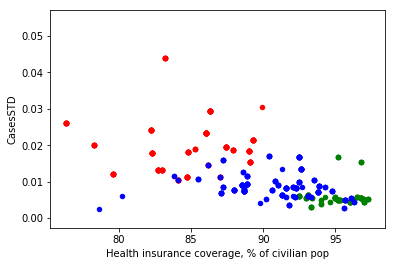

In [287]:
ax1 = zero.plot(kind='scatter', x='Health insurance coverage, % of civilian pop', y='CasesSTD', color='r')    #Zero schools r red
ax2 = one.plot(kind='scatter', x='Health insurance coverage, % of civilian pop', y='CasesSTD', color='g', ax=ax1)    #one schools r green
ax3 = two.plot(kind='scatter', x='Health insurance coverage, % of civilian pop', y='CasesSTD', color='b', ax=ax1)    #two schools r blue

## Population Vs Cases

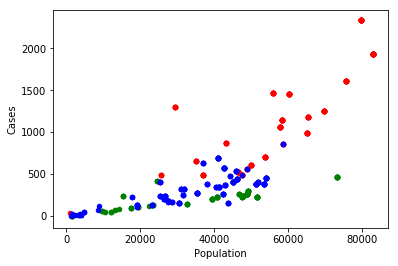

In [285]:
ax1 = zero.plot(kind='scatter', x='Population', y='Cases', color='r')    #Zero schools r red
ax2 = one.plot(kind='scatter', x='Population', y='Cases', color='g', ax=ax1)    #one schools r green
ax3 = two.plot(kind='scatter', x='Population', y='Cases', color='b', ax=ax1)    #two schools r blue

## Worked At Home Standerdized vs Cases Standerdized

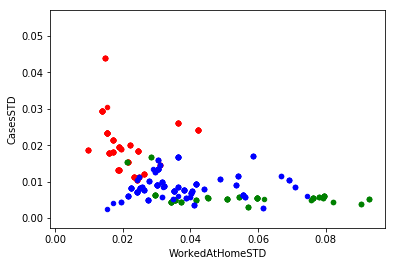

In [269]:
ax1 = zero.plot(kind='scatter', x='WorkedAtHomeSTD', y='CasesSTD', color='r')    #Zero schools r red
ax2 = one.plot(kind='scatter', x='WorkedAtHomeSTD', y='CasesSTD', color='g', ax=ax1)    #one schools r green
ax3 = two.plot(kind='scatter', x='WorkedAtHomeSTD', y='CasesSTD', color='b', ax=ax1)    #two schools r blue

## HouseholdsIncome0kto35kSTD vs Cases Standerdized

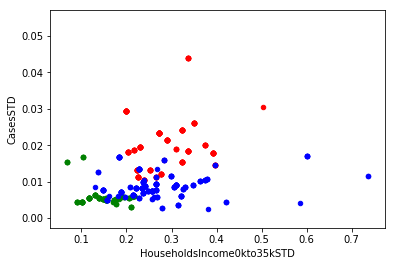

In [270]:
ax1 = zero.plot(kind='scatter', x='HouseholdsIncome0kto35kSTD', y='CasesSTD', color='r')    #Zero schools r red
ax2 = one.plot(kind='scatter', x='HouseholdsIncome0kto35kSTD', y='CasesSTD', color='g', ax=ax1)    #one schools r green
ax3 = two.plot(kind='scatter', x='HouseholdsIncome0kto35kSTD', y='CasesSTD', color='b', ax=ax1)    #two schools r blue

## HouseholdsIncome35kto100kSTD vs Cases Standerdized

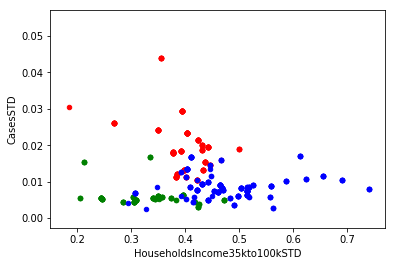

In [271]:
ax1 = zero.plot(kind='scatter', x='HouseholdsIncome35kto100kSTD', y='CasesSTD', color='r')    #Zero schools r red
ax2 = one.plot(kind='scatter', x='HouseholdsIncome35kto100kSTD', y='CasesSTD', color='g', ax=ax1)    #one schools r green
ax3 = two.plot(kind='scatter', x='HouseholdsIncome35kto100kSTD', y='CasesSTD', color='b', ax=ax1)    #two schools r blue

## HouseholdsIncome100kPlusSTD vs Cases Standerdized

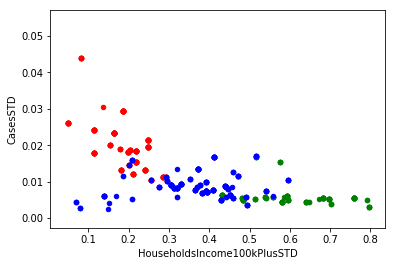

In [272]:
ax1 = zero.plot(kind='scatter', x='HouseholdsIncome100kPlusSTD', y='CasesSTD', color='r')    #Zero schools r red
ax2 = one.plot(kind='scatter', x='HouseholdsIncome100kPlusSTD', y='CasesSTD', color='g', ax=ax1)    #one schools r green
ax3 = two.plot(kind='scatter', x='HouseholdsIncome100kPlusSTD', y='CasesSTD', color='b', ax=ax1)    #two schools r blue

## Children of the household 6-17 vs Cases Standerdized

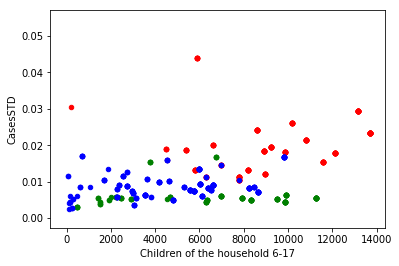

In [273]:
ax1 = zero.plot(kind='scatter', x='Children of the household 6-17', y='CasesSTD', color='r')    #Zero schools r red
ax2 = one.plot(kind='scatter', x='Children of the household 6-17', y='CasesSTD', color='g', ax=ax1)    #one schools r green
ax3 = two.plot(kind='scatter', x='Children of the household 6-17', y='CasesSTD', color='b', ax=ax1)    #two schools r blue

# Mean family income (dollars) vs Cases Standerdized

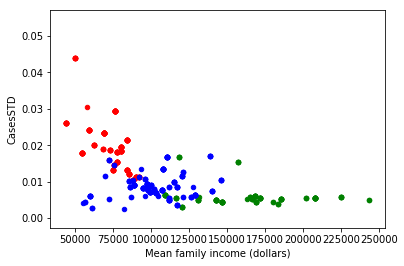

In [274]:
ax1 = zero.plot(kind='scatter', x='Mean family income (dollars)', y='CasesSTD', color='r')    #Zero schools r red
ax2 = one.plot(kind='scatter', x='Mean family income (dollars)', y='CasesSTD', color='g', ax=ax1)    #one schools r green
ax3 = two.plot(kind='scatter', x='Mean family income (dollars)', y='CasesSTD', color='b', ax=ax1)    #two schools r blue

## Latino% vs Cases std

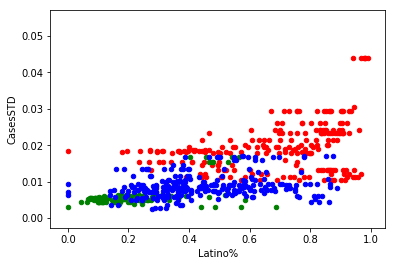

In [283]:
ax1 = zero.plot(kind='scatter', x='Latino%', y='CasesSTD', color='r')    #Zero schools r red
ax2 = one.plot(kind='scatter', x='Latino%', y='CasesSTD', color='g', ax=ax1)    #one schools r green
ax3 = two.plot(kind='scatter', x='Latino%', y='CasesSTD', color='b', ax=ax1)    #two schools r blue

## CumulativeEnrollment vs Cases Std

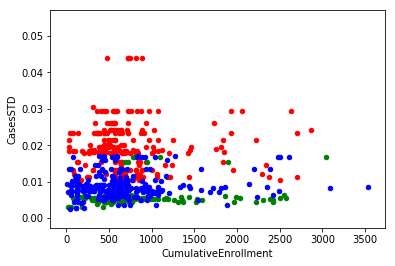

In [282]:
ax1 = zero.plot(kind='scatter', x='CumulativeEnrollment', y='CasesSTD', color='r')    #Zero schools r red
ax2 = one.plot(kind='scatter', x='CumulativeEnrollment', y='CasesSTD', color='g', ax=ax1)    #one schools r green
ax3 = two.plot(kind='scatter', x='CumulativeEnrollment', y='CasesSTD', color='b', ax=ax1)    #two schools r blue

* red high
* blue mid
* green low

In [300]:
done_shorter[done_shorter['CumulativeEnrollment'] < 100]['predictions'].value_counts()

2    16
0     8
1     4
Name: predictions, dtype: int64

In [275]:
zero.columns

Index(['EILName', 'Latitude', 'Longitude', 'Address', 'Zipcode',
       'School, District', 'DistrictName', 'CumulativeEnrollment', 'Latino%',
       'Median family income (dollars)', 'Mean family income (dollars)',
       'Health insurance coverage, % of civilian pop',
       'No health insurance for civilian pop',
       'No health insurance coverage %', 'Worked at home', 'Population 16+',
       'Children of the household 6-17', 'Households with income $0-34,999',
       'Households with income $35,000-99,999',
       'Households with income $100,000+', 'Percent Increase',
       'Absolute Increase Standardized', 'Cases', 'Population',
       'WorkedAtHomeSTD', 'HouseholdsIncome0kto35kSTD',
       'HouseholdsIncome35kto100kSTD', 'HouseholdsIncome100kPlusSTD',
       'CasesSTD', 'predictions'],
      dtype='object')

In [290]:
corr = done_shorter.corr().drop(['Latitude','Longitude','No health insurance coverage %','Median family income (dollars)','Zipcode']).drop([
    'Latitude','Longitude','No health insurance coverage %','Median family income (dollars)','Zipcode'],axis = 1)

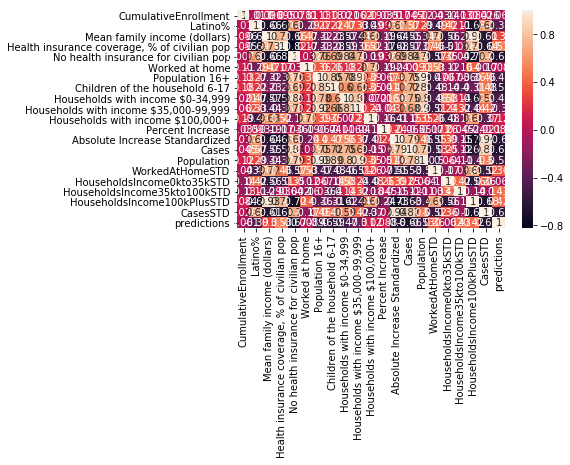

In [291]:
import seaborn as sns 
  
# generating correlation heatmap 
sns.heatmap(corr, annot = True) 

In [278]:
done_shorter.to_csv(r'C:/Users/Andrew Chin/border_chlng/Datasets/done_shorter.csv')